### SVR
Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

In [1]:
# lets import the dependencies

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import validation_curve

from sklearn.preprocessing import PowerTransformer

from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# loading the data
# loading our data
df = pd.read_csv("./Data/data.csv",sep=",")
df.drop(['Unnamed: 0'], axis=1, inplace=True) # There were some formatting issues while
                                              # writing the csv

In [3]:
df.head()

,DISTRICT,UPAZILA,STATION_ID,STATION_NAME,DATE,RAIN_FALL(mm),LATITUDE,LONGITUDE,WATER_LEVEL(m)
0,Bandarban,Lama,CL317,Lama,01-jan-2017,0.0,21.81,92.19,6.22
1,Bandarban,Lama,CL317,Lama,02-jan-2017,0.0,21.81,92.19,6.22
2,Bandarban,Lama,CL317,Lama,03-jan-2017,0.0,21.81,92.19,6.22
3,Bandarban,Lama,CL317,Lama,04-jan-2017,0.0,21.81,92.19,6.21
4,Bandarban,Lama,CL317,Lama,05-jan-2017,0.0,21.81,92.19,6.21


Defining our X and y

In [4]:
X = df['RAIN_FALL(mm)'].values.reshape(-1,1) # input feature
y = df['WATER_LEVEL(m)'].values.reshape(-1,1) # target feature

making the train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=17, shuffle=True
)

#### PreProcessing

#### Power Transformation

In [6]:
pt = PowerTransformer(method='box-cox')
X_train_transformed = pt.fit_transform(X_train+0.000001)
X_test_transformed = pt.transform(X_test+0.000001)

In [7]:
pt.lambdas_

array([-0.10662485])

In [8]:
y_train_transformed = pt.fit_transform(y_train+0.000001)
y_test_transformed = pt.transform(y_test+0.000001)
y_train_transformed = y_train_transformed.ravel()
y_test_transformed = y_test_transformed.ravel()

In [9]:
pt.lambdas_

array([-5.34754941])

#### Model Building

Initialize our CV

In [10]:
kfold = KFold(n_splits=5,shuffle=True,random_state=17)

Initialize Support Vector Regressor with default parameters:
- kernel: rbf
- tol : 1e-3
- C: 1
- epsilon: 0.1
- verbose:True
- max_iteration: -1

In [11]:
svr = SVR()

CV Scores:

In [12]:
results = cross_val_score(
    svr,
    X_train_transformed,
    y_train_transformed,
    cv=kfold,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.5760287054297919

Note: 
- we got 0.44 in KNN

Train-test accuracy

In [13]:
svr.fit(X_train_transformed,y_train_transformed)

SVR()

In [14]:
# accuracy on the train set
pred = svr.predict(X_train_transformed)
mean_absolute_error(y_train_transformed,pred)

0.5751854260156385

In [15]:
# accuracy on the test set
pred = svr.predict(X_test_transformed)
mean_absolute_error(y_test_transformed,pred)

0.570577574929561

#### Learning Curve

lets plot the learning curve to see how our dataset's size influence the model accuracy 

In [16]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [17]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        svr,X_train_transformed,y_train_transformed, \
        train_sizes=train_sizes,cv=kfold,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

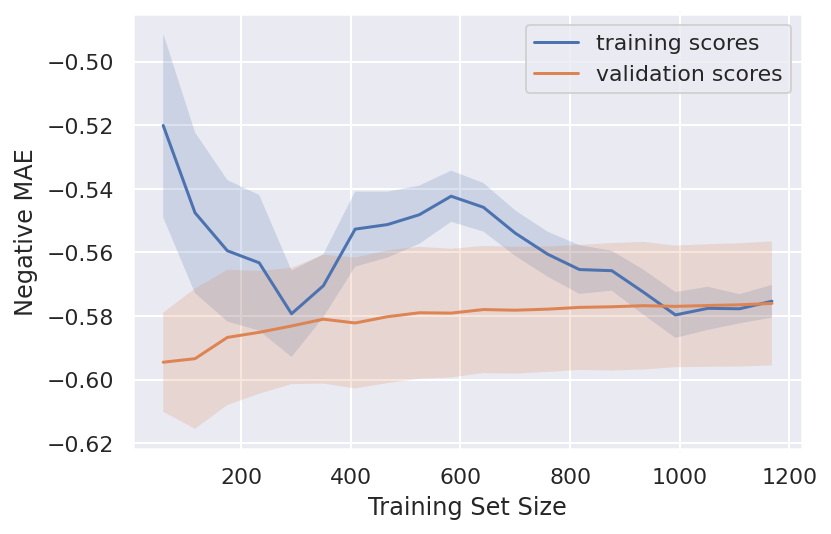

In [18]:
plot_learning_curve()

Note:
- its clear that training and validation curve converges, assuaring no variance problem in the data

#### Validation Curves

In [19]:
# helper function
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [20]:
def plot_validation_curve(param_grid,param,estimator):
    val_train, val_test = validation_curve(
    estimator=estimator,
    X=X_train_transformed,
    y=y_train_transformed,
    param_name=param,
    param_range=param_grid,
    cv=kfold,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
    )

    plot_with_err(param_grid, val_train, label="training scores")
    plot_with_err(param_grid, val_test, label="validation scores")
    plt.xlabel(param)
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

- **C:** Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

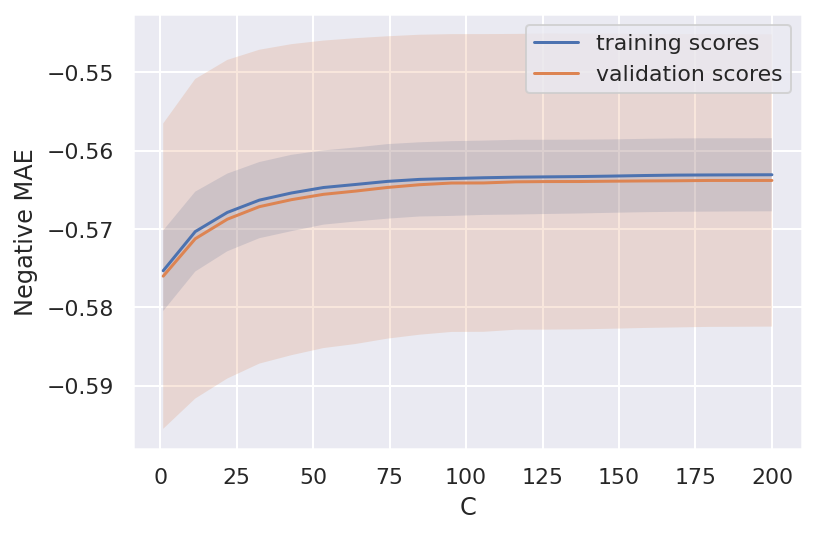

In [21]:
plot_validation_curve(np.linspace(1,200,20),'C',svr)

Note:
- After 75, there's no significant improvement

- **epsilon:** Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

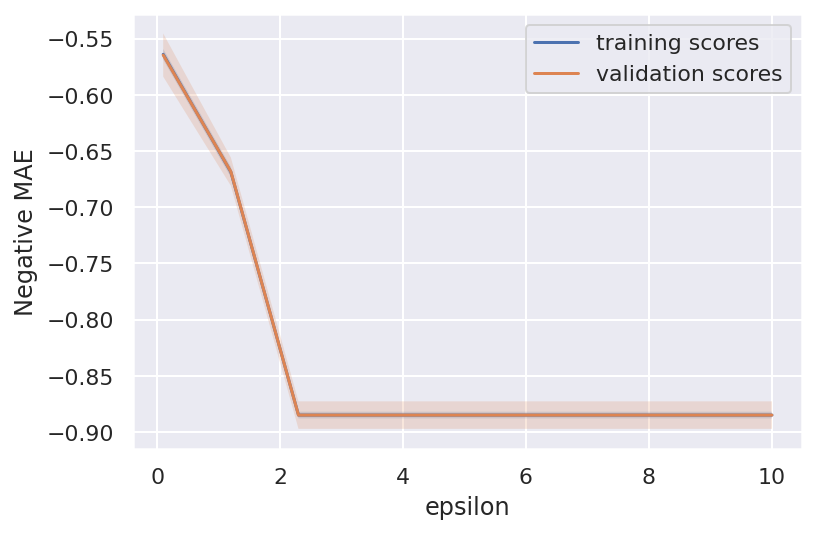

In [22]:
svr = SVR(C=80)
plot_validation_curve(np.linspace(0.1,10,10),'epsilon',svr)

#### Hyper-Parameter Tuning:

In [23]:
svr_params = {
    'C': np.linspace(1,200,20),
    'epsilon': np.linspace(0.01,10,10)
}
svr = SVR()
gcv = GridSearchCV(svr,svr_params,n_jobs=-1,cv=kfold,verbose=1,\
    scoring='neg_mean_absolute_error')

In [24]:
# training the model
gcv.fit(X_train_transformed,y_train_transformed)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([  1.        ,  11.47368421,  21.94736842,  32.42105263,
        42.89473684,  53.36842105,  63.84210526,  74.31578947,
        84.78947368,  95.26315789, 105.73684211, 116.21052632,
       126.68421053, 137.15789474, 147.63157895, 158.10526316,
       168.57894737, 179.05263158, 189.52631579, 200.        ]),
                         'epsilon': array([ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89,
       10.  ])},
             scoring='neg_mean_absolute_error', verbose=1)

In [25]:
# the best score
gcv.best_score_

-0.5636756238996249

In [26]:
# the best estimators parameters
gcv.best_params_

{'C': 179.05263157894734, 'epsilon': 0.01}

In [27]:
# Lets check the train test accuracy of our model
svr_pred = gcv.best_estimator_.predict(X_train_transformed)
mean_absolute_error(y_train_transformed,svr_pred)

0.5627343535124258

In [28]:
# Lets check the test test accuracy of our model
svr_pred = gcv.best_estimator_.predict(X_test_transformed)
mean_absolute_error(y_test_transformed,svr_pred)

0.5623383600494728

#### Learning Curve

In [29]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        gcv.best_estimator_,X_train_transformed,y_train_transformed, \
        train_sizes=train_sizes,cv=kfold,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

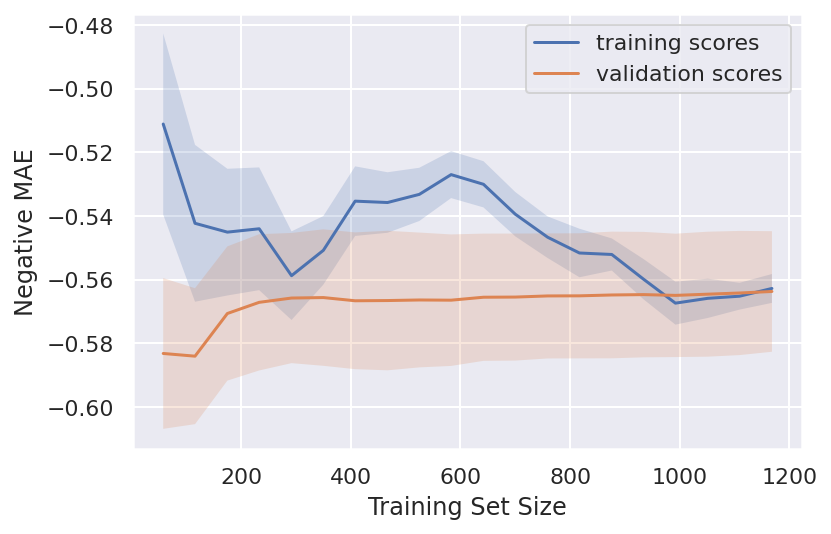

In [30]:
plot_learning_curve()